In [1]:
!pip install distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 418.3 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16276 sha256=9b0c226b703bc3cd95b377e6f1bafa6978be9fbfff18c6b0bc71f61399882058
  Stored in directory: /root/.cache/pip/wheels/b2/10/1b/96fca621a1be378e2fe104cfb0d160bb6cdf3d04a3d35266cc
Successfully built distance


In [2]:
!pip install fuzzywuzzy

In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, nltk, re, distance
warnings.filterwarnings('ignore')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tqdm.notebook import tqdm
tqdm.pandas()
from fuzzywuzzy import fuzz
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout   
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_precision_recall_curve
import joblib

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
train = pd.read_csv('../input/training-data/train.csv')
train = train.sample(n=100000).reset_index(drop=True)
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,242192,354361,354362,Could you explain for me the sentence “play li...,Does somebody Could help me learning English? ...,0
1,51605,80258,91510,How would anyone convince his wife to reconcil...,"Donald Trump: If he divorces his wife, how eas...",0
2,214292,319826,319827,How do I mitigate the delay of construction pr...,Does Bill Gates do any construction projects?,0
3,328809,455393,455394,When were the first sewers built in Europe?,When was the first sewer built in Europe and h...,1
4,288008,43325,138206,How should I prepare myself for campus placeme...,How do I prepare for campus placement?,1


In [6]:
train.shape

(100000, 6)

In [7]:
train.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [8]:
train = train.dropna()

In [9]:
train.duplicated().sum()

0

In [10]:
def text_preprocess(ques):
    ques = str(ques).lower().strip()

    ques = ques.replace('%',' percent')
    ques = ques.replace('$',' dollar ')
    ques = ques.replace('₹', ' rupee ')
    ques = ques.replace('€', ' euro ')
    ques = ques.replace('@', ' at ')
    ques = ques.replace('[math]','')
    ques = ques.replace(',000,000,000 ', 'b ')
    ques = ques.replace(',000,000 ', 'm ')
    ques = ques.replace(',000 ', 'k ')
    ques = re.sub(r'([0-9]+)000000000', r'\1b', ques)
    ques = re.sub(r'([0-9]+)000000', r'\1m', ques)
    ques = re.sub(r'([0-9]+)000', r'\1k', ques)

    # Decontract words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    decontracted_ques = []

    for word in ques.split():
      if word in contractions:
        word = contractions[word]
      decontracted_ques.append(word)
    
    ques = ' '.join(decontracted_ques)
    ques = ques.replace("'ve", " have")
    ques = ques.replace("n't", " not")
    ques = ques.replace("'re", " are")
    ques = ques.replace("'ll", " will")
    ques = re.sub(r"[^A-Za-z0-9]", " ", ques)
    ques = re.sub('[,\.\(\)?"\']'," ",ques)
    ques = re.sub(r"what's", "", ques)
    ques = re.sub(r"What's", "", ques)
    ques = re.sub(r"\'s", " ", ques)
    ques = re.sub(r"\'ve", " have ", ques)
    ques = re.sub(r"can't", "cannot ", ques)
    ques = re.sub(r"n't", " not ", ques)
    ques = re.sub(r"I'm", "I am", ques)
    ques = re.sub(r" m ", " am ", ques)
    ques = re.sub(r"\'re", " are ", ques)
    ques = re.sub(r"\'d", " would ", ques)
    ques = re.sub(r"\'ll", " will ", ques)
    ques = re.sub(r"\0k ", "0000 ", ques)
    ques = re.sub(r" e g ", " eg ", ques)
    ques = re.sub(r" b g ", " bg ", ques)
    ques = re.sub(r"\0s", "0", ques)
    ques = re.sub(r" 9 11 ", "911", ques)
    ques = re.sub(r"e-mail", "email", ques)
    ques = re.sub(r"\s{2,}", " ", ques)
    ques = re.sub(r"quikly", "quickly", ques)
    ques = re.sub(r" usa ", " America ", ques)
    ques = re.sub(r" USA ", " America ", ques)
    ques = re.sub(r" u s ", " America ", ques)
    ques = re.sub(r" uk ", " England ", ques)
    ques = re.sub(r" UK ", " England ", ques)
    ques = re.sub(r"india", "India", ques)
    ques = re.sub(r"china", "China", ques)
    ques = re.sub(r"chinese", "Chinese", ques) 
    ques = re.sub(r"imrovement", "improvement", ques)
    ques = re.sub(r"intially", "initially", ques)
    ques = re.sub(r"quora", "Quora", ques)
    ques = re.sub(r" dms ", "direct messages ", ques)  
    ques = re.sub(r"demonitization", "demonetization", ques) 
    ques = re.sub(r"actived", "active", ques)
    ques = re.sub(r"kms", " kilometers ", ques)
    ques = re.sub(r"KMs", " kilometers ", ques)
    ques = re.sub(r" cs ", " computer science ", ques) 
    ques = re.sub(r" upvotes ", " up votes ", ques)
    ques = re.sub(r" iPhone ", " phone ", ques)
    ques = re.sub(r"\0rs ", " rs ", ques) 
    ques = re.sub(r"calender", "calendar", ques)
    ques = re.sub(r"ios", "operating system", ques)
    ques = re.sub(r"gps", "GPS", ques)
    ques = re.sub(r"gst", "GST", ques)
    ques = re.sub(r"programing", "programming", ques)
    ques = re.sub(r"bestfriend", "best friend", ques)
    ques = re.sub(r"dna", "DNA", ques)
    ques = re.sub(r"III", "3", ques) 
    ques = re.sub(r"the US", "America", ques)
    ques = re.sub(r"Astrology", "astrology", ques)
    ques = re.sub(r"Method", "method", ques)
    ques = re.sub(r"Find", "find", ques) 
    ques = re.sub(r"banglore", "Banglore", ques)
    ques = re.sub(r" J K ", " JK ", ques)

    # Eliminate HTML tags
    ques = BeautifulSoup(ques)
    ques = ques.get_text()

    # Remove punctuation characters
    pattern = re.compile('\W')
    ques = re.sub(pattern,' ',ques).strip()
    
    return ques

In [11]:
train.question1 = train.question1.progress_apply(text_preprocess)
train.question2 = train.question2.progress_apply(text_preprocess)

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [12]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,242192,354361,354362,could you explain for me the sentence play lik...,does somebody could help me learning english i...,0
1,51605,80258,91510,how would anyone convince his wife to reconcil...,donald trump if he divorces his wife how easy ...,0
2,214292,319826,319827,how do i mitigate the delay of construction pr...,does bill gates do any construction projects,0
3,328809,455393,455394,when were the first sewers built in europe,when was the first sewer built in europe and h...,1
4,288008,43325,138206,how should i prepare myself for campus placements,how do i prepare for campus placement,1


In [13]:
train['q1_len'] = train.question1.apply(len)
train['q2_len'] = train.question2.apply(len)

In [14]:
train['q1_num_words'] = train.question1.apply(lambda sent: len(sent.split()))
train['q2_num_words'] = train.question2.apply(lambda sent: len(sent.split()))

In [15]:
def common_words(row):
    wq1 = set(map(lambda x: x.lower().strip(),row['question1'].split()))
    wq2 = set(map(lambda x: x.lower().strip(),row['question2'].split()))
    return len(wq1 & wq2)

In [16]:
train['common_words'] = train.apply(common_words,axis=1)
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words
0,242192,354361,354362,could you explain for me the sentence play lik...,does somebody could help me learning english i...,0,119,70,24,13,6
1,51605,80258,91510,how would anyone convince his wife to reconcil...,donald trump if he divorces his wife how easy ...,0,118,119,23,25,8
2,214292,319826,319827,how do i mitigate the delay of construction pr...,does bill gates do any construction projects,0,51,44,9,7,2
3,328809,455393,455394,when were the first sewers built in europe,when was the first sewer built in europe and h...,1,42,73,8,14,6
4,288008,43325,138206,how should i prepare myself for campus placements,how do i prepare for campus placement,1,49,37,8,7,5


In [17]:
def total_words(row):
  wq1 = set(map(lambda x: x.lower().strip(), row['question1'].split()))
  wq2 = set(map(lambda x: x.lower().strip(), row['question2'].split()))
  return len(wq1) + len(wq2)

In [18]:
train['total_words'] = train.apply(total_words,axis=1)
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words
0,242192,354361,354362,could you explain for me the sentence play lik...,does somebody could help me learning english i...,0,119,70,24,13,6,33
1,51605,80258,91510,how would anyone convince his wife to reconcil...,donald trump if he divorces his wife how easy ...,0,118,119,23,25,8,44
2,214292,319826,319827,how do i mitigate the delay of construction pr...,does bill gates do any construction projects,0,51,44,9,7,2,16
3,328809,455393,455394,when were the first sewers built in europe,when was the first sewer built in europe and h...,1,42,73,8,14,6,22
4,288008,43325,138206,how should i prepare myself for campus placements,how do i prepare for campus placement,1,49,37,8,7,5,15


In [19]:
train['shared_words'] = round(train.common_words / train.total_words,2)
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,shared_words
0,242192,354361,354362,could you explain for me the sentence play lik...,does somebody could help me learning english i...,0,119,70,24,13,6,33,0.18
1,51605,80258,91510,how would anyone convince his wife to reconcil...,donald trump if he divorces his wife how easy ...,0,118,119,23,25,8,44,0.18
2,214292,319826,319827,how do i mitigate the delay of construction pr...,does bill gates do any construction projects,0,51,44,9,7,2,16,0.12
3,328809,455393,455394,when were the first sewers built in europe,when was the first sewer built in europe and h...,1,42,73,8,14,6,22,0.27
4,288008,43325,138206,how should i prepare myself for campus placements,how do i prepare for campus placement,1,49,37,8,7,5,15,0.33


In [20]:
def generate_token_features(row):
  ques1 = row['question1']
  ques2 = row['question2']
  dummy = 0.0001
  token_features = np.zeros((8,),'float32')
  q1_len, q2_len = len(ques1), len(ques2)
  tokens_ques1 = ques1.split()
  tokens_ques2 = ques2.split()

  if len(tokens_ques1) == 0 or len(tokens_ques2) == 0:
    return token_features
  
  non_stopwords_q1 = set([word for word in tokens_ques1 if word not in stopwords.words('english')])
  non_stopwords_q2 = set([word for word in tokens_ques2 if word not in stopwords.words('english')])

  stopwords_q1 = set([word for word in tokens_ques1 if word in stopwords.words('english')])
  stopwords_q2 = set([word for word in tokens_ques2 if word in stopwords.words('english')])
  common_word_count = len(non_stopwords_q1.intersection(non_stopwords_q2))
  common_stop_count = len(stopwords_q1.intersection(stopwords_q2))
  common_token_count = len(set(tokens_ques1).intersection(set(tokens_ques2)))
  
  token_features[0] = common_word_count / (min(q1_len,q2_len) + dummy)
  token_features[1] = common_word_count / (max(q1_len,q2_len) + dummy)
  token_features[2] = common_stop_count / (min(q1_len,q2_len) + dummy)
  token_features[3] = common_stop_count / (max(q1_len,q2_len) + dummy)
  token_features[4] = common_token_count / (min(q1_len,q2_len) + dummy)
  token_features[5] = common_token_count / (max(q1_len,q2_len) + dummy)
  token_features[6] = int(tokens_ques1[0] == tokens_ques2[0])
  token_features[7] = int(tokens_ques1[-1] == tokens_ques2[-1])

  return token_features

In [21]:
token_features = train.progress_apply(generate_token_features,axis=1)

train['cwc_min'] = list(map(lambda x: x[0], token_features))
train['cwc_max'] = list(map(lambda x: x[1], token_features))
train['csc_min'] = list(map(lambda x: x[2], token_features))
train['csc_max'] = list(map(lambda x: x[3], token_features))
train['ctc_min'] = list(map(lambda x: x[4], token_features))
train['ctc_max'] = list(map(lambda x: x[5], token_features))
train['first_word_same'] = list(map(lambda x: x[6], token_features))
train['last_word_same'] = list(map(lambda x: x[7], token_features))

train.head()

  0%|          | 0/100000 [00:00<?, ?it/s]

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,total_words,shared_words,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,first_word_same,last_word_same
0,242192,354361,354362,could you explain for me the sentence play lik...,does somebody could help me learning english i...,0,119,70,24,13,...,33,0.18,0.028571,0.016807,0.057143,0.033613,0.085714,0.050420,0.0,0.0
1,51605,80258,91510,how would anyone convince his wife to reconcil...,donald trump if he divorces his wife how easy ...,0,118,119,23,25,...,44,0.18,0.016949,0.016807,0.050847,0.050420,0.067797,0.067227,0.0,0.0
2,214292,319826,319827,how do i mitigate the delay of construction pr...,does bill gates do any construction projects,0,51,44,9,7,...,16,0.12,0.022727,0.019608,0.022727,0.019608,0.045454,0.039216,0.0,0.0
3,328809,455393,455394,when were the first sewers built in europe,when was the first sewer built in europe and h...,1,42,73,8,14,...,22,0.27,0.071428,0.041096,0.071428,0.041096,0.142857,0.082192,1.0,0.0
4,288008,43325,138206,how should i prepare myself for campus placements,how do i prepare for campus placement,1,49,37,8,7,...,15,0.33,0.054054,0.040816,0.081081,0.061224,0.135135,0.102041,1.0,0.0


In [22]:
def generate_length_features(row):   
    ques1 = row['question1']
    ques2 = row['question2']  
    length_features = np.zeros((3,),'float32')
    q1_tokens = ques1.split()
    q2_tokens = ques2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features

    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    strs = list(distance.lcsubstrings(ques1, ques2))
    length_features[2] = len(strs) / (min(len(ques1), len(ques2)) + 1) 
    return length_features

In [23]:
length_features = train.progress_apply(generate_length_features,axis=1)

train['mean_ques_len'] = list(map(lambda x: x[0], length_features))
train['abs_len_diff'] = list(map(lambda x: x[1], length_features))
train['longest_sub_ratio'] = list(map(lambda x: x[2], length_features))

train.head()

  0%|          | 0/100000 [00:00<?, ?it/s]

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,cwc_max,csc_min,csc_max,ctc_min,ctc_max,first_word_same,last_word_same,mean_ques_len,abs_len_diff,longest_sub_ratio
0,242192,354361,354362,could you explain for me the sentence play lik...,does somebody could help me learning english i...,0,119,70,24,13,...,0.016807,0.057143,0.033613,0.085714,0.050420,0.0,0.0,11.0,18.5,0.014085
1,51605,80258,91510,how would anyone convince his wife to reconcil...,donald trump if he divorces his wife how easy ...,0,118,119,23,25,...,0.016807,0.050847,0.050420,0.067797,0.067227,0.0,0.0,2.0,24.0,0.008403
2,214292,319826,319827,how do i mitigate the delay of construction pr...,does bill gates do any construction projects,0,51,44,9,7,...,0.019608,0.022727,0.019608,0.045454,0.039216,0.0,0.0,2.0,8.0,0.022222
3,328809,455393,455394,when were the first sewers built in europe,when was the first sewer built in europe and h...,1,42,73,8,14,...,0.041096,0.071428,0.041096,0.142857,0.082192,1.0,0.0,6.0,11.0,0.046512
4,288008,43325,138206,how should i prepare myself for campus placements,how do i prepare for campus placement,1,49,37,8,7,...,0.040816,0.081081,0.061224,0.135135,0.102041,1.0,0.0,1.0,7.5,0.026316


In [24]:
def generate_fuzzy_features(row):
  ques1 = row['question1']
  ques2 = row['question2']

  fuzz_features = np.zeros((4,),'float32')

  # fuzz ratio
  fuzz_features[0] = fuzz.QRatio(ques1,ques2)
  # fuzz partial ratio
  fuzz_features[1] = fuzz.partial_ratio(ques1,ques2)
  # token set ratio
  fuzz_features[2] = fuzz.token_set_ratio(ques1,ques2)
  # token sort ratio
  fuzz_features[3] = fuzz.token_sort_ratio(ques1,ques2)

  return fuzz_features

In [25]:
fuzz_features = train.progress_apply(generate_fuzzy_features,axis=1)

train['fuzz_ratio'] = list(map(lambda x: x[0],fuzz_features))
train['fuzz_partial_ratio'] = list(map(lambda x: x[1],fuzz_features))
train['token_set_ratio'] = list(map(lambda x: x[2],fuzz_features))
train['token_sort_ratio'] = list(map(lambda x: x[3],fuzz_features))

train.head()

  0%|          | 0/100000 [00:00<?, ?it/s]

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,ctc_max,first_word_same,last_word_same,mean_ques_len,abs_len_diff,longest_sub_ratio,fuzz_ratio,fuzz_partial_ratio,token_set_ratio,token_sort_ratio
0,242192,354361,354362,could you explain for me the sentence play lik...,does somebody could help me learning english i...,0,119,70,24,13,...,0.050420,0.0,0.0,11.0,18.5,0.014085,46.0,49.0,53.0,46.0
1,51605,80258,91510,how would anyone convince his wife to reconcil...,donald trump if he divorces his wife how easy ...,0,118,119,23,25,...,0.067227,0.0,0.0,2.0,24.0,0.008403,47.0,47.0,59.0,52.0
2,214292,319826,319827,how do i mitigate the delay of construction pr...,does bill gates do any construction projects,0,51,44,9,7,...,0.039216,0.0,0.0,2.0,8.0,0.022222,72.0,71.0,69.0,63.0
3,328809,455393,455394,when were the first sewers built in europe,when was the first sewer built in europe and h...,1,42,73,8,14,...,0.082192,1.0,0.0,6.0,11.0,0.046512,66.0,90.0,83.0,66.0
4,288008,43325,138206,how should i prepare myself for campus placements,how do i prepare for campus placement,1,49,37,8,7,...,0.102041,1.0,0.0,1.0,7.5,0.026316,84.0,81.0,81.0,79.0


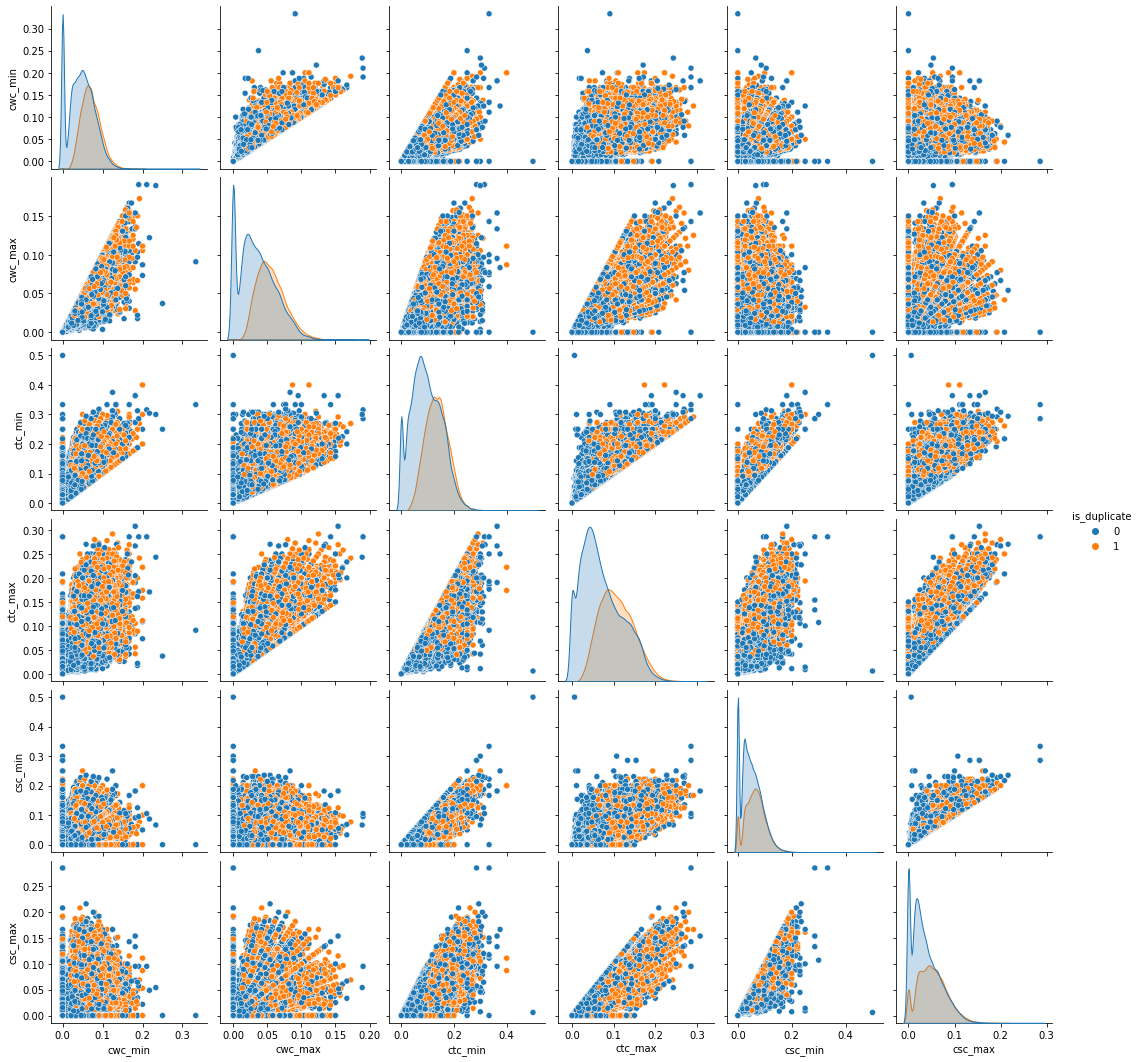

In [26]:
sns.pairplot(train[['cwc_min','cwc_max','ctc_min','ctc_max','csc_min','csc_max','is_duplicate']],hue='is_duplicate')

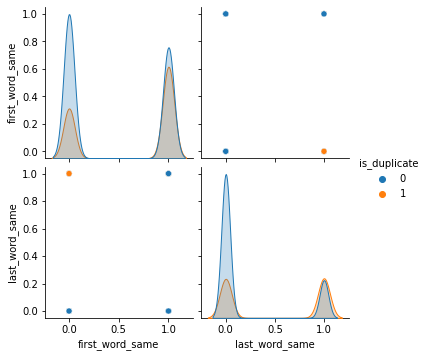

In [27]:
sns.pairplot(train[['first_word_same','last_word_same','is_duplicate']],hue='is_duplicate')

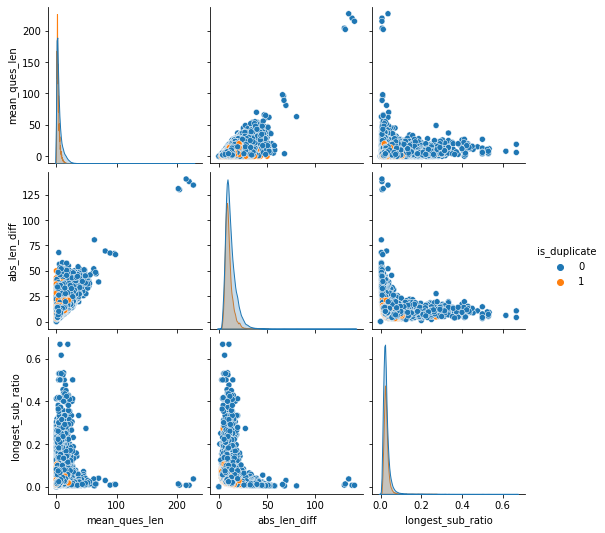

In [28]:
sns.pairplot(train[['mean_ques_len','abs_len_diff','longest_sub_ratio','is_duplicate']],hue='is_duplicate')

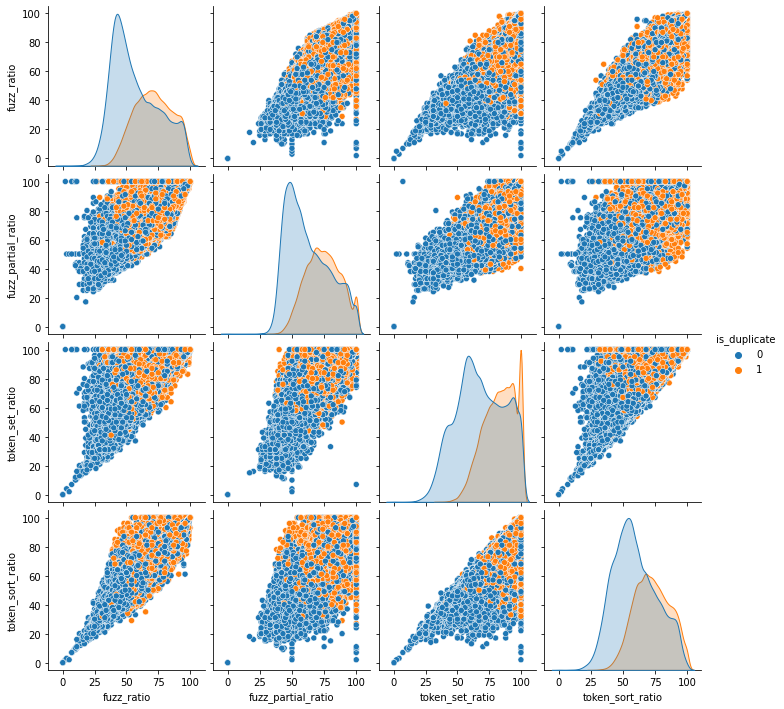

In [29]:
sns.pairplot(train[['fuzz_ratio','fuzz_partial_ratio','token_set_ratio','token_sort_ratio','is_duplicate']],hue='is_duplicate')

In [30]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train[['cwc_min','cwc_max','ctc_min','ctc_max','csc_min','csc_max','first_word_same','last_word_same','abs_len_diff','mean_ques_len','longest_sub_ratio','fuzz_ratio','fuzz_partial_ratio','token_set_ratio','token_sort_ratio']])
target = train.is_duplicate.values

In [31]:
pca = PCA(n_components=2,random_state=101)
X_pca = pca.fit_transform(scaled_train)

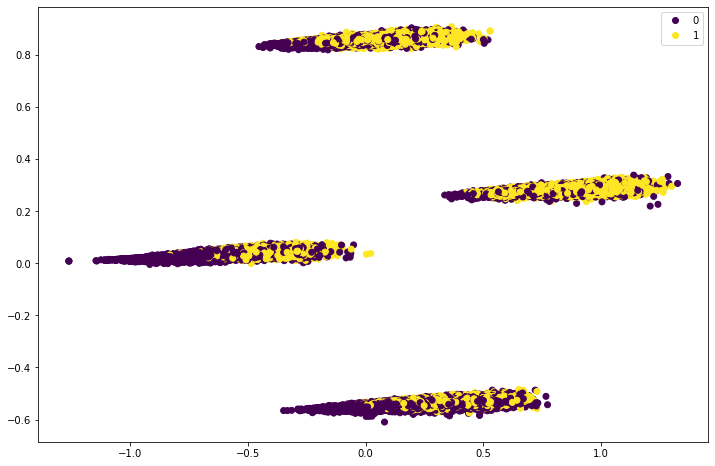

In [32]:
plt.figure(figsize=(12,8))
fig = plt.scatter(X_pca[:,0],X_pca[:,1],c=target)
plt.legend(handles=fig.legend_elements()[0],labels=list([0,1]))
plt.show();

In [33]:
rest_data = train.drop(['id','qid1','qid2','question1','question2'],axis=1)
rest_data.head()

,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,shared_words,cwc_min,cwc_max,...,ctc_max,first_word_same,last_word_same,mean_ques_len,abs_len_diff,longest_sub_ratio,fuzz_ratio,fuzz_partial_ratio,token_set_ratio,token_sort_ratio
0,0,119,70,24,13,6,33,0.18,0.028571,0.016807,...,0.050420,0.0,0.0,11.0,18.5,0.014085,46.0,49.0,53.0,46.0
1,0,118,119,23,25,8,44,0.18,0.016949,0.016807,...,0.067227,0.0,0.0,2.0,24.0,0.008403,47.0,47.0,59.0,52.0
2,0,51,44,9,7,2,16,0.12,0.022727,0.019608,...,0.039216,0.0,0.0,2.0,8.0,0.022222,72.0,71.0,69.0,63.0
3,1,42,73,8,14,6,22,0.27,0.071428,0.041096,...,0.082192,1.0,0.0,6.0,11.0,0.046512,66.0,90.0,83.0,66.0
4,1,49,37,8,7,5,15,0.33,0.054054,0.040816,...,0.102041,1.0,0.0,1.0,7.5,0.026316,84.0,81.0,81.0,79.0


In [34]:
ques_df = train[['question1','question2']]
ques_df.head()

,question1,question2
0,could you explain for me the sentence play lik...,does somebody could help me learning english i...
1,how would anyone convince his wife to reconcil...,donald trump if he divorces his wife how easy ...
2,how do i mitigate the delay of construction pr...,does bill gates do any construction projects
3,when were the first sewers built in europe,when was the first sewer built in europe and h...
4,how should i prepare myself for campus placements,how do i prepare for campus placement


In [35]:
questions = np.array(list(ques_df.question1) + list(ques_df.question2))
cv = CountVectorizer(max_features=500)
ques1_arr, ques2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [36]:
q1_temp = pd.DataFrame(ques1_arr)
q2_temp = pd.DataFrame(ques2_arr)
ques = pd.concat([q1_temp,q2_temp],axis=1)
ques.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
ques.index = rest_data.index

In [38]:
df = pd.concat([rest_data,ques],axis=1)
df.head()

,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,shared_words,cwc_min,cwc_max,...,490,491,492,493,494,495,496,497,498,499
0,0,119,70,24,13,6,33,0.18,0.028571,0.016807,...,0,0,0,0,0,0,0,0,0,0
1,0,118,119,23,25,8,44,0.18,0.016949,0.016807,...,0,2,0,0,0,0,0,0,0,0
2,0,51,44,9,7,2,16,0.12,0.022727,0.019608,...,0,0,0,0,0,0,0,0,0,0
3,1,42,73,8,14,6,22,0.27,0.071428,0.041096,...,0,0,0,0,0,0,0,0,0,0
4,1,49,37,8,7,5,15,0.33,0.054054,0.040816,...,0,0,0,0,0,0,0,0,0,0


In [39]:
X = df.drop('is_duplicate',axis=1)
y = df.is_duplicate

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=101)

In [41]:
features = X_train.columns
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_train = pd.DataFrame(scaled_X_train,columns=features)
scaled_X_train.head()

,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,shared_words,cwc_min,cwc_max,csc_min,...,490,491,492,493,494,495,496,497,498,499
0,0.087087,0.062500,0.054054,0.047619,0.075,0.089172,0.38,0.206903,0.143836,0.103449,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.327327,0.038732,0.324324,0.038961,0.050,0.165605,0.14,0.000000,0.000000,0.130436,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.099099,0.029930,0.094595,0.030303,0.125,0.082803,0.66,0.181824,0.291667,0.272729,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.135135,0.043134,0.121622,0.038961,0.200,0.095541,0.94,0.266675,0.411766,0.266668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.228228,0.071303,0.189189,0.056277,0.300,0.165605,0.86,0.315800,0.506026,0.157896,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
scaled_X_test = scaler.transform(X_test)
scaled_X_test = pd.DataFrame(scaled_X_test,columns=features)
scaled_X_test.head()

,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,shared_words,cwc_min,cwc_max,csc_min,...,490,491,492,493,494,495,496,497,498,499
0,0.117117,0.039613,0.121622,0.051948,0.175,0.114650,0.70,0.307702,0.446810,0.230771,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.099099,0.037852,0.081081,0.025974,0.125,0.070064,0.76,0.272736,0.350001,0.181819,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.303303,0.080986,0.256757,0.082251,0.150,0.197452,0.36,0.127664,0.207922,0.063830,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.144144,0.043134,0.108108,0.034632,0.100,0.095541,0.48,0.125004,0.205883,0.125001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.138138,0.027289,0.108108,0.021645,0.100,0.076433,0.58,0.181824,0.228261,0.181819,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
def train_and_evaluate_model(model):
    model.fit(scaled_X_train,y_train)
    pred = model.predict(scaled_X_test)
    print(classification_report(y_test,pred))
    plot_confusion_matrix(model,scaled_X_test,y_test)
    plot_precision_recall_curve(model,scaled_X_test,y_test)

              precision    recall  f1-score   support

           0       0.80      0.84      0.82     12579
           1       0.70      0.64      0.67      7421

    accuracy                           0.76     20000
   macro avg       0.75      0.74      0.74     20000
weighted avg       0.76      0.76      0.76     20000



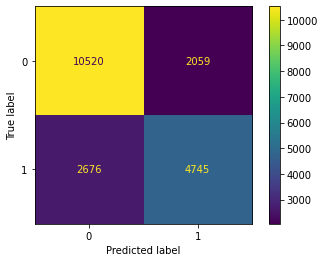

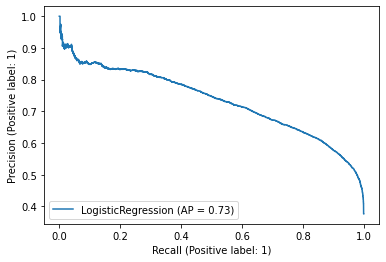

In [44]:
train_and_evaluate_model(LogisticRegression())

              precision    recall  f1-score   support

           0       0.83      0.85      0.84     12579
           1       0.73      0.71      0.72      7421

    accuracy                           0.80     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.79      0.80      0.79     20000



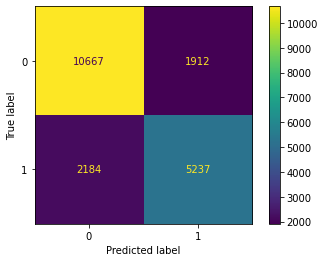

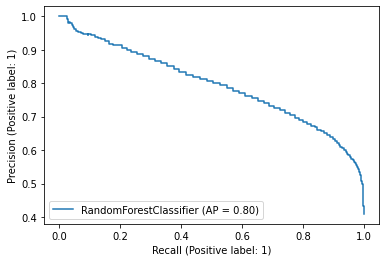

In [45]:
train_and_evaluate_model(RandomForestClassifier())

              precision    recall  f1-score   support

           0       0.78      0.78      0.78     12579
           1       0.63      0.63      0.63      7421

    accuracy                           0.73     20000
   macro avg       0.71      0.71      0.71     20000
weighted avg       0.73      0.73      0.73     20000



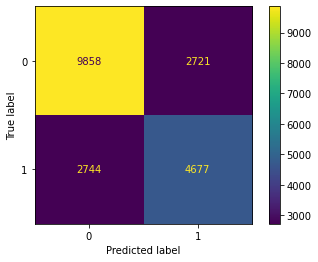

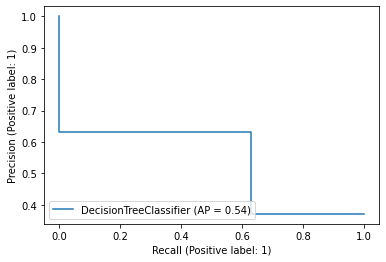

In [46]:
train_and_evaluate_model(DecisionTreeClassifier())

              precision    recall  f1-score   support

           0       0.80      0.84      0.82     12579
           1       0.71      0.65      0.68      7421

    accuracy                           0.77     20000
   macro avg       0.76      0.75      0.75     20000
weighted avg       0.77      0.77      0.77     20000



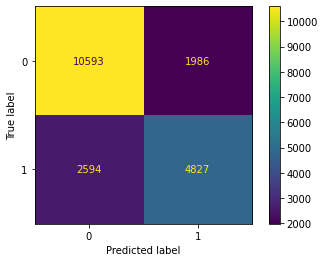

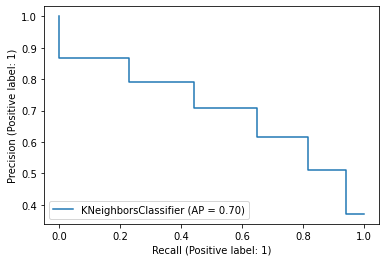

In [47]:
train_and_evaluate_model(KNeighborsClassifier())

              precision    recall  f1-score   support

           0       0.80      0.83      0.82     12579
           1       0.70      0.65      0.67      7421

    accuracy                           0.76     20000
   macro avg       0.75      0.74      0.74     20000
weighted avg       0.76      0.76      0.76     20000



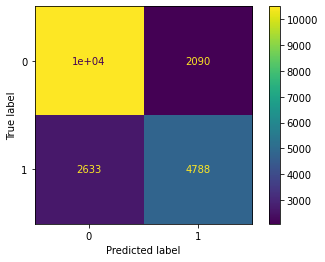

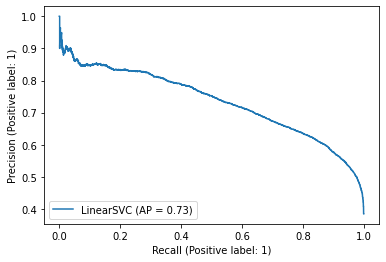

In [48]:
train_and_evaluate_model(LinearSVC())

              precision    recall  f1-score   support

           0       0.77      0.81      0.79     12579
           1       0.64      0.58      0.61      7421

    accuracy                           0.72     20000
   macro avg       0.70      0.70      0.70     20000
weighted avg       0.72      0.72      0.72     20000



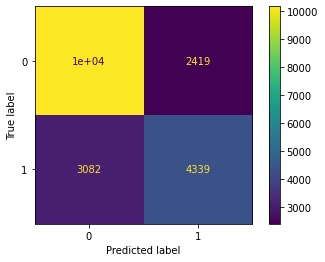

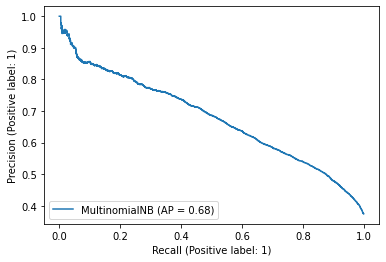

In [49]:
train_and_evaluate_model(MultinomialNB())

              precision    recall  f1-score   support

           0       0.80      0.82      0.81     12579
           1       0.68      0.66      0.67      7421

    accuracy                           0.76     20000
   macro avg       0.74      0.74      0.74     20000
weighted avg       0.76      0.76      0.76     20000



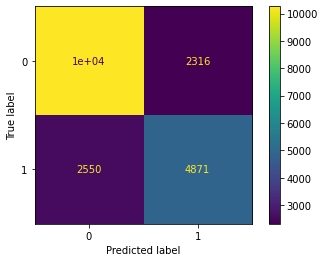

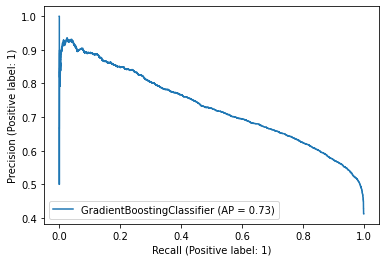

In [50]:
train_and_evaluate_model(GradientBoostingClassifier())

              precision    recall  f1-score   support

           0       0.80      0.79      0.79     12579
           1       0.65      0.66      0.65      7421

    accuracy                           0.74     20000
   macro avg       0.72      0.72      0.72     20000
weighted avg       0.74      0.74      0.74     20000



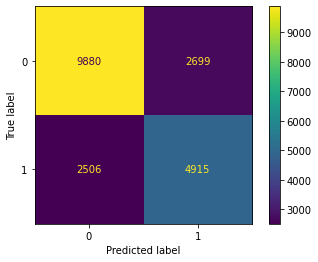

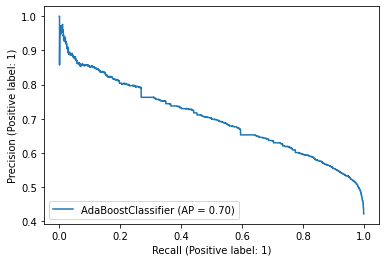

In [51]:
train_and_evaluate_model(AdaBoostClassifier())

              precision    recall  f1-score   support

           0       0.80      0.85      0.82     12579
           1       0.71      0.63      0.67      7421

    accuracy                           0.77     20000
   macro avg       0.75      0.74      0.75     20000
weighted avg       0.76      0.77      0.77     20000



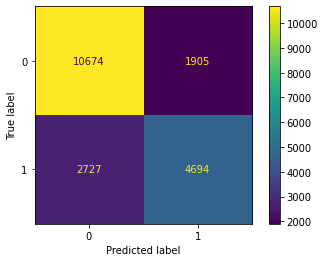

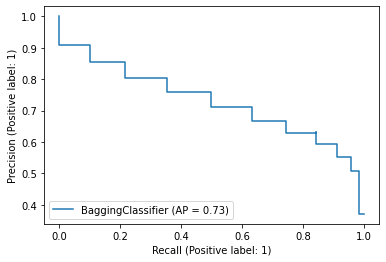

In [93]:
train_and_evaluate_model(BaggingClassifier());

              precision    recall  f1-score   support

           0       0.84      0.87      0.85     12579
           1       0.76      0.71      0.74      7421

    accuracy                           0.81     20000
   macro avg       0.80      0.79      0.80     20000
weighted avg       0.81      0.81      0.81     20000



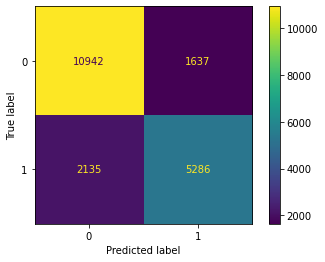

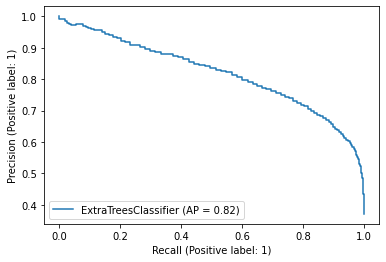

In [94]:
train_and_evaluate_model(ExtraTreesClassifier());

In [80]:
def create_model():
    ann = Sequential()
    ann.add(Dense(units=32,activation='relu'))
    ann.add(Dense(units=64,activation='relu'))
    ann.add(Dense(units=128,activation='relu'))
    ann.add(Dropout(0.28))
    ann.add(Dense(units=1,activation='sigmoid'))
    ann.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')
    return ann

In [85]:
model = create_model()
model

In [86]:
es = EarlyStopping(monitor='val_accuracy',mode='max',patience=40,verbose=1)
rl = ReduceLROnPlateau(monitor='val_accuracy',mode='max',patience=5,verbose=2,min_lr=0.001,factor=0.1)

r = model.fit(scaled_X_train,
         y_train,
         epochs=50,
         batch_size=32,
         validation_data=(scaled_X_test,y_test),
         callbacks=[es,rl])

Epoch 1/50
2500/2500 [==============================] - 11s 4ms/step - loss: 0.4709 - accuracy: 0.7527 - val_loss: 0.4474 - val_accuracy: 0.7679
Epoch 2/50
2500/2500 [==============================] - 10s 4ms/step - loss: 0.4225 - accuracy: 0.7863 - val_loss: 0.4275 - val_accuracy: 0.7844
Epoch 3/50
2500/2500 [==============================] - 9s 4ms/step - loss: 0.3974 - accuracy: 0.8034 - val_loss: 0.4256 - val_accuracy: 0.7869
Epoch 4/50
2500/2500 [==============================] - 10s 4ms/step - loss: 0.3748 - accuracy: 0.8182 - val_loss: 0.4299 - val_accuracy: 0.7913
Epoch 5/50
2500/2500 [==============================] - 10s 4ms/step - loss: 0.3539 - accuracy: 0.8319 - val_loss: 0.4441 - val_accuracy: 0.7862
Epoch 6/50
2500/2500 [==============================] - 10s 4ms/step - loss: 0.3353 - accuracy: 0.8420 - val_loss: 0.4597 - val_accuracy: 0.7760
Epoch 7/50
2500/2500 [==============================] - 10s 4ms/step - loss: 0.3195 - accuracy: 0.8501 - val_loss: 0.4694 - val_acc

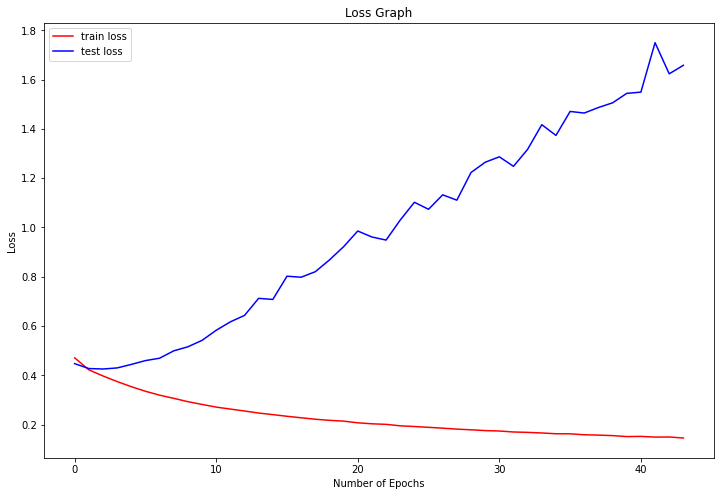

In [87]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

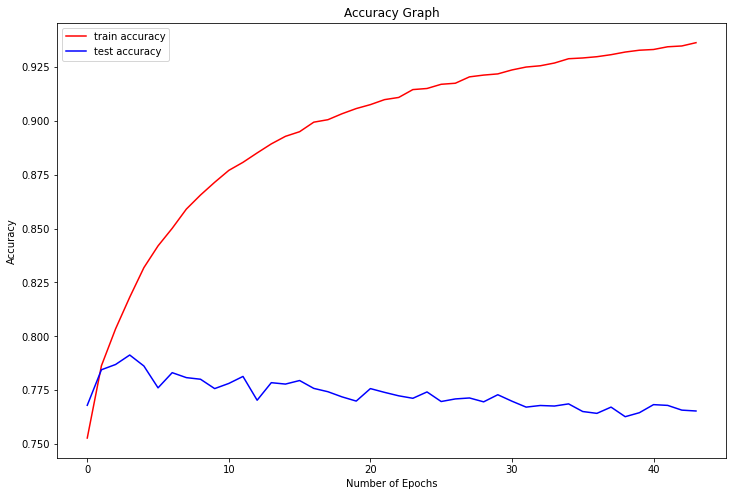

In [88]:
plt.figure(figsize=(12,8))
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [89]:
loss, acc = model.evaluate(scaled_X_test,y_test)
print("Test Loss:",loss)
print("Test Accuracy:",acc)

625/625 [==============================] - 1s 2ms/step - loss: 1.6579 - accuracy: 0.7653
Test Loss: 1.657896876335144
Test Accuracy: 0.7652999758720398


In [91]:
model.save('quora_duplicate_detector.h5')
lm = load_model('quora_duplicate_detector.h5')
lm

In [96]:
et = ExtraTreesClassifier()
et.fit(scaled_X_train,y_train)

ExtraTreesClassifier()

In [97]:
joblib.dump(et,'extra_trees_clf.h5',compress=2)

['extra_trees_clf.h5']